## Multi-classification problem


In [1]:
# Uncomment the next line to install packages
# !pip install torch torchvision matplotlib pandas seaborn requests 

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import requests
import os


import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\abdul\anaconda3\envs\tf2x\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

PyTorch provides two powerful data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as prepare your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [4]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir('USPS/'):
    os.mkdir('USPS/')
open('USPS/usps.bz2', 'wb').write(r.content)

6579383

In [5]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

In [6]:
# Get info from dataset
dataset

Dataset USPS
    Number of datapoints: 7291
    Root location: USPS/
    StandardTransform
Transform: ToTensor()

In [7]:
# Obtain the inputs and targets:
inputs = dataset.data
targets = dataset.targets

In [8]:
# Let's look at a data point
sample_index = 88

data_sample = dataset.data[sample_index]
target_sample = dataset.targets[sample_index]
print("Sample type and shape : ",type(data_sample),data_sample.shape)
print("Label type and value : " ,type(target_sample),target_sample)

Sample type and shape :  <class 'numpy.ndarray'> (16, 16)
Label type and value :  <class 'int'> 9


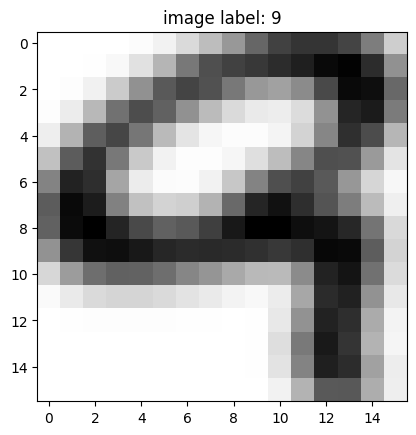

In [9]:
sample_index = 88
plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])
plt.show()

## Pytorch Tensor

Pytorch Documentation : https://pytorch.org/docs/stable/index.html

In [10]:
tensor_data_point = torch.tensor(data_sample)
print("Tensor type :",type(tensor_data_point),", and shape : ",tensor_data_point.shape)

Tensor type : <class 'torch.Tensor'> , and shape :  torch.Size([16, 16])


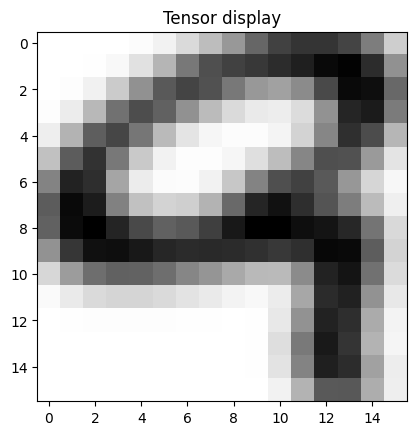

In [11]:
# Pyplot can manage torch Tensors
plt.imshow(tensor_data_point, cmap=plt.cm.gray_r)
plt.title("Tensor display")
plt.show()

In [12]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

## Build your Neural Network
The `torch.nn` namespace provides all the building blocks you need to create your own neural network such as fully connected layers or convolutional layers etc. We define our neural network by subclassing `nn.Module`, and the neural network layers are initialized in **\__init\__**. Every `nn.Module` subclass implements the operations on input data in the **forward** method.

Inheritance in Python (https://www.programiz.com/python-programming/inheritance)

In [13]:
# base model
class base_Model(nn.Module):
    
    def __init__(self, activation, hidden_size):
        super().__init__()
        # We allocate space for the weights
        self.l1 = nn.Linear(16*16, hidden_size)
        self.l2 = nn.Linear(hidden_size, 10)
        self.activation = activation
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        h = self.activation(self.l1(inputs)) # You can put anything, as long as its Pytorch functions
        outputs = F.softmax(self.l2(h), dim=1)# Use softmax as the activation function for the last layer
        return outputs
    

class custmize_Model(nn.Module):
    
    def __init__(self, activation, hidden_size):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
        self.activation = activation
        
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.activation(self.conv2(x))
#         x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 8 * 8)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_accuracy = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        correct = 0
        for (images, labels) in train_loader:
            y_pre = model(images.view(batch_size, -1)) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)

            # calculate acuracy
            _, predicted = torch.max(y_pre, 1) 
            correct += (predicted==labels).sum()

            # calculate and backpropagate loss
            loss = criterion(y_pre, labels_one_hot) if str(criterion) == "MSELoss()" else criterion(y_pre, labels) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
            
            
        train_accuracy.append(100 * correct.item()/len(dataset))
        train_error.append(epoch_average_loss)

    return sum(train_accuracy)/len(train_accuracy), train_accuracy


# define a function for training
def train2(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_accuracy = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        correct = 0
        for (images, labels) in train_loader:
            y_pre = model(images) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)

            # calculate acuracy
            _, predicted = torch.max(y_pre, 1) 
            correct += (predicted==labels).sum()

            # calculate and backpropagate loss
            loss = criterion(y_pre, labels_one_hot) if str(criterion) == "MSELoss()" else criterion(y_pre, labels) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
            
        
        train_accuracy.append(100 * correct.item()/len(dataset))
        train_error.append(epoch_average_loss)

    return sum(train_accuracy)/len(train_accuracy), train_accuracy

Description of AutoGrad (https://pytorch.org/docs/stable/notes/autograd.html)

## Train Base Model

In [14]:
param_grid = {
    'activation': [torch.nn.ReLU(), torch.nn.Tanh(), torch.nn.Sigmoid()],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [10, 20, 30],
    'hiden_size': [64, 128, 256],
    'optimizer': [optim.SGD, optim.Adam, optim.Adagrad],
    'loss': [nn.MSELoss(), nn.CrossEntropyLoss()]
}

epochs = 10
base_best_acc = -np.inf
base_best_params = None

for activation in param_grid['activation']:
    for hiden_size in param_grid['hiden_size']:
        for learning_rate in param_grid['learning_rate']:
            for optimizer_class in param_grid['optimizer']:
                for batch_size in param_grid['batch_size']:
                    for loss in param_grid['loss']:
                        # Create the model: 
                        model = base_Model(activation, hiden_size)
                        optimizer = optimizer_class(model.parameters(), lr=learning_rate)
                        train_accuracy, scores = train(epochs, batch_size, loss, optimizer, model, train_set)
                        train_accuracy  = float("{:.2f}".format(train_accuracy))
                        
                        print("Hyper Parameters: activation-function: {}, hiden-size: {}, learning-rate: {}, optmizer: {}, batch-size: {}, loss-function: {}".
                              format(activation, hiden_size, learning_rate, str(optimizer_class), batch_size, loss))
                        print("Accuracy Score: {}".format(train_accuracy))
                        print("=========================================\n")
                        
                        # Update the best hyperparameters and accuracy
                        if train_accuracy > base_best_acc:
                            base_best_acc = train_accuracy
                            base_best_params = {'activation': activation, 'learning_rate': learning_rate,
                                           'optimizer': optimizer_class, 'hiden_size': hiden_size,
                                          'batch_size': batch_size, 'loss': loss}

print("Best Hyper parameters for Classification Model")
print(base_best_params)

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 28.65

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 42.51

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 16.29

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 31.94

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 12.17

Hyper Parameters: activation-function

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 65.07

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 7.63

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 1.88

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 12.37

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 10.07

Hyper Paramet

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 94.44

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 92.45

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 13.3

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 29.9

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 9.86

Hyper Parameters

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 27.76

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 38.3

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 41.83

Hyper Parameters: activation-function: ReLU(), hiden-size: 256, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 29.74

Hyper Parameters: activation-function: ReLU(), hiden-size: 256, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 4

Hyper Parameters: activation-function: ReLU(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 86.73

Hyper Parameters: activation-function: ReLU(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 77.92

Hyper Parameters: activation-function: ReLU(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 86.91

Hyper Parameters: activation-function: ReLU(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 73.61

Hyper Parameters: activation-function: ReLU(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 1

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 93.67

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 94.39

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 93.39

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 94.17

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Sc

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 30.45

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 30.79

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 32.84

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 30.34

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: MSELoss()
Accuracy S

Hyper Parameters: activation-function: Tanh(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 93.36

Hyper Parameters: activation-function: Tanh(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 84.78

Hyper Parameters: activation-function: Tanh(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 75.42

Hyper Parameters: activation-function: Tanh(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 83.17

Hyper Parameters: activation-function: Tanh(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accurac

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 92.7

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 92.72

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 93.1

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 95.28

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 94.72

Hyp

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 88.73

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 85.38

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 86.79

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 80.32

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 40.17

Hyper 

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 64, learning-rate: 0.001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 92.45

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 64, learning-rate: 0.001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 86.97

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 64, learning-rate: 0.001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 90.41

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 64, learning-rate: 0.001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 81.38

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 64, learning-rate: 0.001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 88.88

Hyper P

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 16.01

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 20.15

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 95.49

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 94.31

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 95.84

Hyper Param

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 8.88

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 8.98

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 7.35

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 14.08

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 75.36

Hyper Pa

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 12.26

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 16.02

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 9.97

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 15.31

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 9.22

Hyper Paramete

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 29.68

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 16.31

Best Hyper parameters for Classification Model


NameError: name 'best_params' is not defined

## Train Customize Model

In [35]:
param_grid = {
    'activation': [torch.nn.ReLU(), torch.nn.Tanh(), torch.nn.Sigmoid()],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [10, 20, 30],
    'hiden_size': [64, 128, 256],
    'optimizer': [optim.SGD, optim.Adam, optim.Adagrad],
    'loss': [nn.MSELoss(), nn.CrossEntropyLoss()]
}

epochs = 10
custom_best_acc = -np.inf
custom_best_params = None

for activation in param_grid['activation']:
    for hiden_size in param_grid['hiden_size']:
        for learning_rate in param_grid['learning_rate']:
            for optimizer_class in param_grid['optimizer']:
                for batch_size in param_grid['batch_size']:
                    for loss in param_grid['loss']:
                        # Create the model: 
                        model = custmize_Model(activation, hiden_size)
                        optimizer = optimizer_class(model.parameters(), lr=learning_rate)
                        train_accuracy, scores = train2(epochs, batch_size, loss, optimizer, model, train_set)
                        train_accuracy = float("{:.2f}".format(train_accuracy))
                        
                        print("Hyper Parameters: activation-function: {}, hiden-size: {}, learning-rate: {}, optmizer: {}, batch-size: {}, loss-function: {}".
                              format(activation, hiden_size, learning_rate, str(optimizer_class), batch_size, loss))
                        print("Accuracy Score: {}".format(train_accuracy))
                        print("=========================================\n")
                        
                        # Update the best hyperparameters and accuracy
                        if train_accuracy > custom_best_acc:
                            custom_best_acc = train_accuracy
                            custom_best_params = {'activation': activation, 'learning_rate': learning_rate,
                                           'optimizer': optimizer_class, 'hiden_size': hiden_size,
                                          'batch_size': batch_size, 'loss': loss}

                            
print("Best Hyper parameters for Classification Model")
print(custom_best_params)

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 77.55

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 90.94

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 70.22

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 88.71

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 55.61

Hyper Parameters: activation-function

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 89.52

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 18.31

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 24.1

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 16.3

Hyper Parameters: activation-function: ReLU(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 16.37

Hyper Paramet

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 94.69

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 97.03

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 32.51

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 66.6

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 29.31

Hyper Paramete

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 64.77

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 76.89

Hyper Parameters: activation-function: ReLU(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 68.55

Hyper Parameters: activation-function: ReLU(), hiden-size: 256, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 80.15

Hyper Parameters: activation-function: ReLU(), hiden-size: 256, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 

Hyper Parameters: activation-function: ReLU(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 95.63

Hyper Parameters: activation-function: ReLU(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 92.63

Hyper Parameters: activation-function: ReLU(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 95.03

Hyper Parameters: activation-function: ReLU(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 92.54

Hyper Parameters: activation-function: ReLU(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 1

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 96.92

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 14.98

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 81.12

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 15.08

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Sc

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 84.22

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 71.98

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 83.93

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 67.62

Hyper Parameters: activation-function: Tanh(), hiden-size: 64, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: MSELoss()
Accuracy S

Hyper Parameters: activation-function: Tanh(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 97.46

Hyper Parameters: activation-function: Tanh(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 93.91

Hyper Parameters: activation-function: Tanh(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 94.34

Hyper Parameters: activation-function: Tanh(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 92.03

Hyper Parameters: activation-function: Tanh(), hiden-size: 128, learning-rate: 0.001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accurac

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 84.24

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 10.93

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 90.01

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 13.07

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.01, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 98.3

Hy

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 94.75

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 95.19

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 94.47

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 93.92

Hyper Parameters: activation-function: Tanh(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 86.81

Hyper 

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 64, learning-rate: 0.001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 91.19

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 64, learning-rate: 0.001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 91.17

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 64, learning-rate: 0.001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 85.9

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 64, learning-rate: 0.001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 88.48

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 64, learning-rate: 0.001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 82.45

Hyper Pa

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 16.29

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.01, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 16.12

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 11.61

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 12.64

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.01, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 11.69

Hyper Param

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 10.33

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 15.85

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 13.38

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 12.64

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 128, learning-rate: 0.0001, optmizer: <class 'torch.optim.adam.Adam'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 71.98

Hyper

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: MSELoss()
Accuracy Score: 15.95

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 10, loss-function: CrossEntropyLoss()
Accuracy Score: 16.16

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: MSELoss()
Accuracy Score: 16.23

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 20, loss-function: CrossEntropyLoss()
Accuracy Score: 16.11

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 256, learning-rate: 0.001, optmizer: <class 'torch.optim.sgd.SGD'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 16.11

Hyper Parame

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: MSELoss()
Accuracy Score: 16.88

Hyper Parameters: activation-function: Sigmoid(), hiden-size: 256, learning-rate: 0.0001, optmizer: <class 'torch.optim.adagrad.Adagrad'>, batch-size: 30, loss-function: CrossEntropyLoss()
Accuracy Score: 16.21

Best Hyper parameters for Classification Model
{'activation': ReLU(), 'learning_rate': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hiden_size': 256, 'batch_size': 10, 'loss': MSELoss()}


In [40]:
print("\nMaximum Accuracy on best parameters")
print(custom_best_acc)


Maximum Accuracy on best parameters
98.98


## Train Best Params with Different Epochs

In [41]:
_params = base_best_params if base_best_acc > custom_best_acc else custom_best_params
base_flag = True if base_best_acc > custom_best_acc else False

In [46]:
best_acc = -np.inf

epochs_list = [20, 50, 100, 200, 500]

if base_flag:
    for epochs in epochs_list:
        # Create the model: 
        model = base_Model(_params['activation'], _params['hiden_size'])
        optimizer = optimizer_class(model.parameters(), lr=_params['learning_rate'])
        train_accuracy, scores = train(epochs, _params['batch_size'], _params['loss'], optimizer, model, train_set)
        train_accuracy = float("{:.2f}".format(train_accuracy))
        
        print("Accuracy Score on {} epochs: {}".format(epochs, train_accuracy))
        if train_accuracy > best_acc:
            best_acc = train_accuracy
            _params['epochs'] = epochs
else:
    for epochs in epochs_list:
        # Create the model: 
        model = custmize_Model(_params['activation'], _params['hiden_size'])
        optimizer = optimizer_class(model.parameters(), lr=_params['learning_rate'])
        train_accuracy, scores = train2(epochs, _params['batch_size'], _params['loss'], optimizer, model, train_set)
        train_accuracy = float("{:.2f}".format(train_accuracy))
        
        print("Accuracy Score on {} epochs: {}".format(epochs, train_accuracy))
        if train_accuracy > best_acc:
            best_acc = train_accuracy
            _params['epochs'] = epochs
        
print("***** Best Hyper parameters for Classification Model *****\n")
print(_params)

Accuracy Score on 20 epochs: 96.68
Accuracy Score on 50 epochs: 97.66
Accuracy Score on 100 epochs: 98.76
Accuracy Score on 200 epochs: 99.4
Accuracy Score on 500 epochs: 99.73
***** Best Hyper parameters for Classification Model *****

{'activation': ReLU(), 'learning_rate': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hiden_size': 256, 'batch_size': 10, 'loss': MSELoss(), 'epochs': 500}


In [22]:
_params = {'activation': torch.nn.ReLU(), 'learning_rate': 0.001, 'optimizer_class': optim.Adam, 'hiden_size': 256, 'batch_size': 10, 'loss': nn.MSELoss(), 'epochs': 100}

In [23]:
# Create the model: 
model = custmize_Model(_params['activation'], _params['hiden_size'])
optimizer = _params['optimizer_class'](model.parameters(), lr=_params['learning_rate'])
train_accuracy, scores = train2(_params['epochs'], _params['batch_size'], _params['loss'], optimizer, model, train_set)

Text(0.5, 1.0, 'Visualization of convergence')

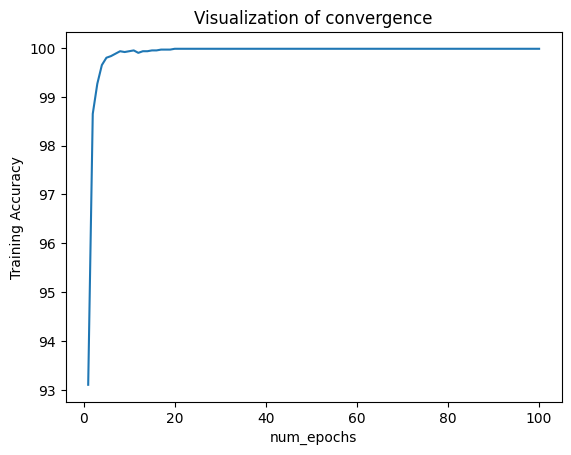

In [26]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, 100+1), scores)
plt.xlabel("num_epochs")
plt.ylabel("Training Accuracy")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

In [50]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
#             images = images.view(-1, 16*16)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

accuracy(val_set, model)

Accuracy of the model : 99.54 %


## Evaluate the Model on Test set

In [51]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

accuracy(test_set, model)

Accuracy of the model : 96.66 %


## Test Single Sample

Text(0.5, 1.0, 'Prediction label: 7')

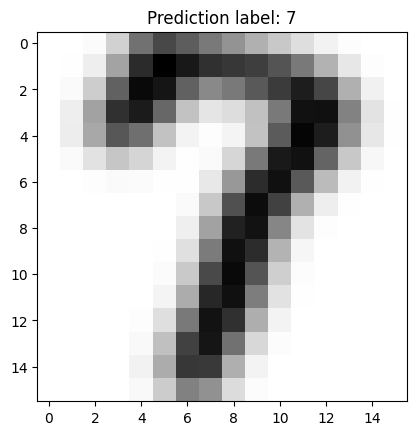

In [53]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image)
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)